In [68]:
# all the libaries that we might possibly need

!pip install shap -q


import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
import joblib
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

# Import filters to remove unnecessary warnings
from warnings import simplefilter
import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import ConvergenceWarning

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# Import filters to remove unnecessary warnings
from warnings import simplefilter
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error
import shap


In [28]:
# Read the Excel file
df = pd.read_excel('BTC_Footprints_v1.xlsx')

# print the type of data each column is
for column in df.columns:
  print(f"Data type: {df[column].dtype}")

Data type: object
Data type: float64
Data type: float64
Data type: float64
Data type: float64
Data type: float64
Data type: float64
Data type: float64
Data type: float64
Data type: float64
Data type: float64
Data type: float64
Data type: float64
Data type: float64
Data type: float64
Data type: float64


In [29]:
# Convert Date column to datetime format and then create numerical features
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Drop the original Date column
df = df.drop('Date', axis=1)

In [30]:
# Check for duplicate rows
duplicates = df.duplicated()
duplicate_rows = df[duplicates]

# Print summary information
print(f"Total number of duplicate rows: {len(duplicate_rows)}")

if len(duplicate_rows) > 0:
    print("\nHere are the duplicate rows:")
    print(duplicate_rows)

    # Get indices of duplicate rows
    print("\nIndices of duplicate rows:")
    print(df[duplicates].index.tolist())

    # To see which rows are duplicates of each other
    print("\nAll rows that have duplicates (including first occurrence):")
    all_duplicates = df[df.duplicated(keep=False)]
    print(all_duplicates.sort_values(by=list(df.columns)))
else:
    print("\nNo duplicate rows found in the dataset.")

# Optional: Count of duplicates for each duplicated row
if len(duplicate_rows) > 0:
    print("\nCount of occurrences for each duplicated row:")
    duplicate_counts = df.groupby(list(df.columns)).size()
    print(duplicate_counts[duplicate_counts > 1])

Total number of duplicate rows: 0

No duplicate rows found in the dataset.


In [31]:
# Check for missing values
print("Missing values count:")
print(df.isnull().sum())

# Options for handling missing values:
# a. Remove rows with missing values
df_cleaned = df.dropna()

# # b. Fill missing values (choose based on your data)
# df['column_name'].fillna(df['column_name'].mean(), inplace=True)  # with mean
# df['column_name'].fillna(df['column_name'].median(), inplace=True)  # with median
# df['column_name'].fillna(df['column_name'].mode()[0], inplace=True)  # with mode

# Save the processed data if needed
df.to_excel('processed_data.xlsx', index=False)

Missing values count:
BTCENEMAX     0
BTCENEMIN     0
BTCENEGUE     0
BTCEMI_MAX    0
BTCEMI_MIN    0
BTCEMI_GUE    0
BTCOAL_MAX    0
BTCOAL_MIN    0
BTCOAL_GUE    0
BTCOIL_MAX    0
BTCOIL_MIN    0
BTCOIL_GUE    0
BTCGAS_MAX    0
BTCGAS_MIN    0
BTCGAS_GUE    0
Year          0
Month         0
Day           0
dtype: int64


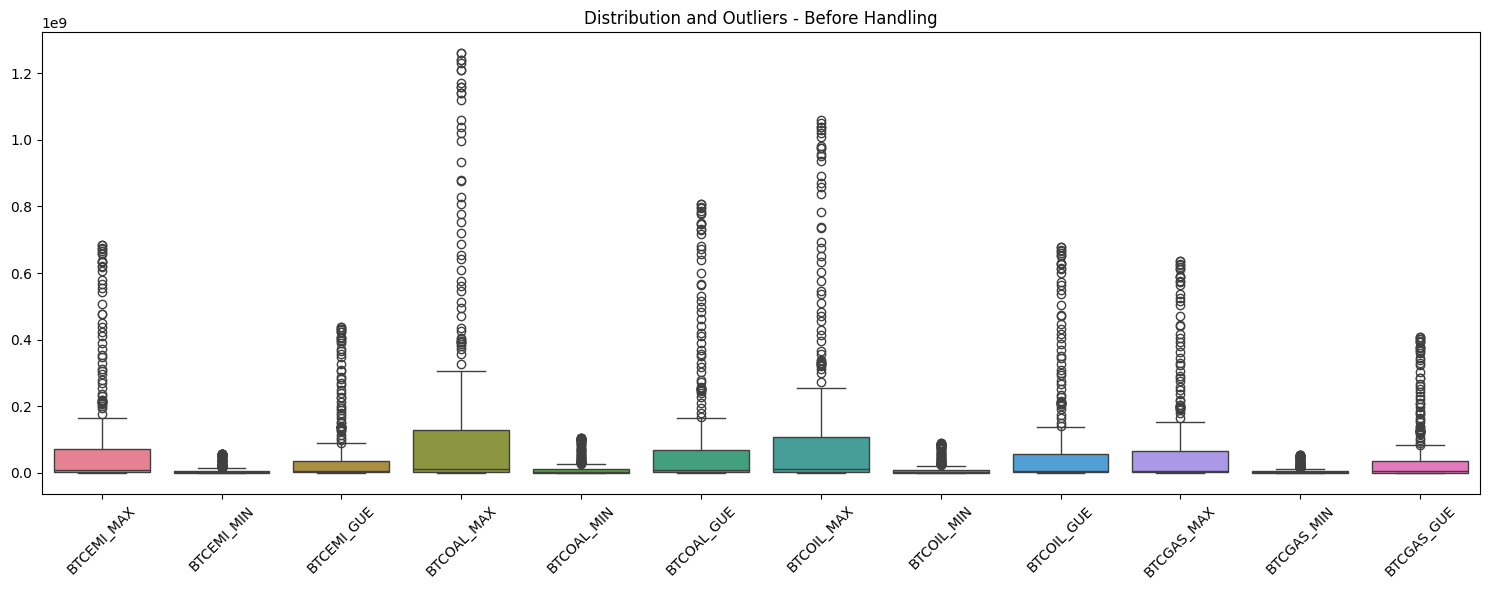


Outliers in BTCEMI_MAX:
Number of outliers: 48
Lower bound: -99791570.0
Upper bound: 172274942.0

Outliers in BTCEMI_MIN:
Number of outliers: 49
Lower bound: -7777188.125000001
Upper bound: 14237441.675

Outliers in BTCEMI_GUE:
Number of outliers: 51
Lower bound: -52290362.5
Upper bound: 90174217.5

Outliers in BTCOAL_MAX:
Number of outliers: 48
Lower bound: -183980117.5
Upper bound: 317588070.5

Outliers in BTCOAL_MIN:
Number of outliers: 49
Lower bound: -14300606.000000002
Upper bound: 26180363.6

Outliers in BTCOAL_GUE:
Number of outliers: 51
Lower bound: -96261107.5
Upper bound: 165996664.5

Outliers in BTCOIL_MAX:
Number of outliers: 48
Lower bound: -154143051.25
Upper bound: 266085830.75

Outliers in BTCOIL_MIN:
Number of outliers: 49
Lower bound: -11988660.875
Upper bound: 21947246.125

Outliers in BTCOIL_GUE:
Number of outliers: 51
Lower bound: -80680360.0
Upper bound: 139128216.0

Outliers in BTCGAS_MAX:
Number of outliers: 48
Lower bound: -92694706.25
Upper bound: 160016823.

In [37]:
# Function to identify outliers using IQR method
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_mask = (df[column] < lower_bound) | (df[column] > upper_bound)
    outliers = df[outliers_mask][column]

    print(f"\nOutliers in {column}:")
    print(f"Number of outliers: {len(outliers)}")
    print(f"Lower bound: {lower_bound}")
    print(f"Upper bound: {upper_bound}")
    return outliers_mask

# Select columns 4 through 15
output_columns = df.iloc[:, 3:15].columns

# Create box plots to visualize outliers before handling
plt.figure(figsize=(15, 6))
sns.boxplot(data=df[output_columns])
plt.xticks(rotation=45)
plt.title('Distribution and Outliers - Before Handling')
plt.tight_layout()
plt.show()

# Dictionary to store outlier masks for each column
outlier_masks = {}

# Identify outliers for each output column
for column in output_columns:
    outlier_masks[column] = identify_outliers(df, column)

Because there aren't too many outliers, we can just deal with the outliers by removing the rows with the outliers.


Original dataset shape: (399, 18)
Shape after removing outliers: (348, 18)


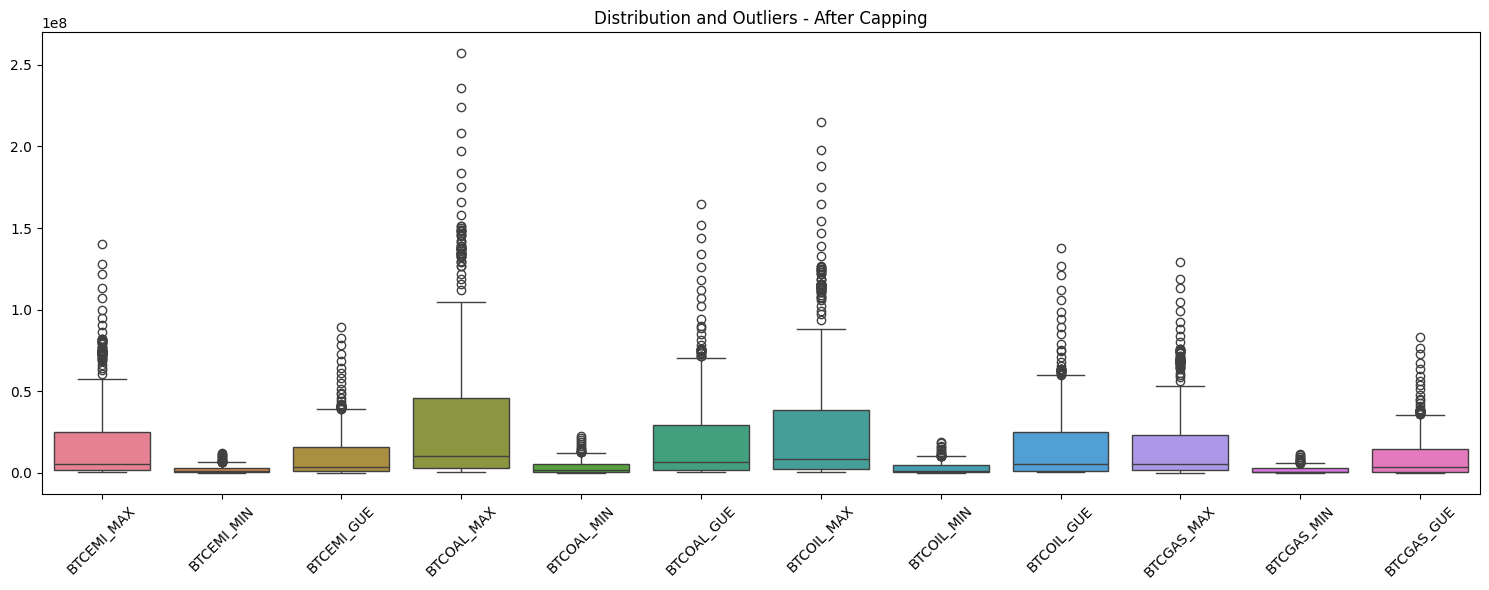

In [38]:
# Dealing with the outliers

# 1. Remove rows with outliers (might remove too much data)
df_removed = df.copy()
combined_mask = pd.Series(False, index=df.index)
for mask in outlier_masks.values():
    combined_mask = combined_mask | mask
df_removed = df_removed[~combined_mask]

print(f"\nOriginal dataset shape: {df.shape}")
print(f"Shape after removing outliers: {df_removed.shape}")

# # 2. Cap the outliers at the bounds (Winsorization)
# df_capped = df.copy()
# for column in output_columns:
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     df_capped[column] = df_capped[column].clip(lower=lower_bound, upper=upper_bound)

# # 3. Replace outliers with median
# df_median = df.copy()
# for column in output_columns:
#     median_val = df[column].median()
#     mask = outlier_masks[column]
#     df_median.loc[mask, column] = median_val

# Visualize the results after capping (you can change this to df_removed or df_median to see other methods)
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_removed[output_columns])
plt.xticks(rotation=45)
plt.title('Distribution and Outliers - After Capping')
plt.tight_layout()
plt.show()

# Save the processed datasets
# df_capped.to_excel('data_outliers_capped.xlsx', index=False)
# df_median.to_excel('data_outliers_median.xlsx', index=False)
df_removed.to_excel('data_outliers_removed.xlsx', index=False)

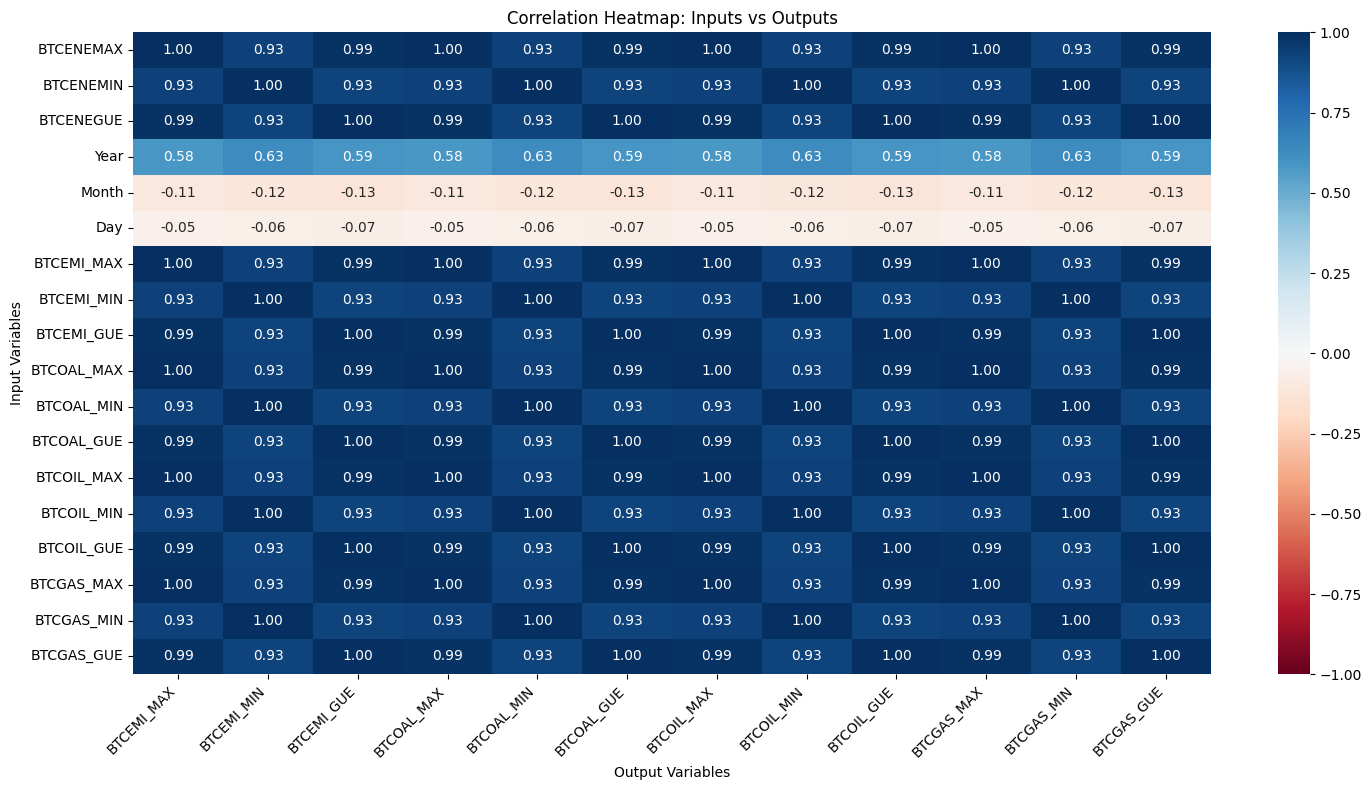

In [65]:
# creating a heat map of the cleaned data
# Read the Excel file
df = pd.read_excel('data_outliers_removed.xlsx')

# Define input and output columns
input_columns = ['BTCENEMAX', 'BTCENEMIN', 'BTCENEGUE', 'Year', 'Month', 'Day',
                 'BTCEMI_MAX', 'BTCEMI_MIN', 'BTCEMI_GUE',
                 'BTCOAL_MAX', 'BTCOAL_MIN', 'BTCOAL_GUE',
                 'BTCOIL_MAX', 'BTCOIL_MIN', 'BTCOIL_GUE',
                 'BTCGAS_MAX', 'BTCGAS_MIN', 'BTCGAS_GUE']
output_columns = ['BTCEMI_MAX', 'BTCEMI_MIN', 'BTCEMI_GUE',
                 'BTCOAL_MAX', 'BTCOAL_MIN', 'BTCOAL_GUE',
                 'BTCOIL_MAX', 'BTCOIL_MIN', 'BTCOIL_GUE',
                 'BTCGAS_MAX', 'BTCGAS_MIN', 'BTCGAS_GUE']

# Calculate correlations between inputs and outputs
correlation_matrix = np.zeros((len(input_columns), len(output_columns)))
for i, input_col in enumerate(input_columns):
    for j, output_col in enumerate(output_columns):
        correlation_matrix[i, j] = df[input_col].corr(df[output_col])

# Convert to DataFrame for better visualization
correlation_df = pd.DataFrame(correlation_matrix,
                            index=input_columns,
                            columns=output_columns)

# Create the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_df,
            annot=True,  # Show correlation values
            cmap='RdBu',  # Red-Blue colormap
            center=0,     # Center the colormap at 0
            vmin=-1,     # Minimum correlation value
            vmax=1,      # Maximum correlation value
            fmt='.2f')   # Format correlation values to 2 decimal places

plt.title('Correlation Heatmap: Inputs vs Outputs')
plt.xlabel('Output Variables')
plt.ylabel('Input Variables')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

Because having all three 'BTCENEMAX', 'BTCENEMIN', 'BTCENEGUE' are similar in correlation, I'll change the dataset so that only 'BTCENEGUE' of the columns will be the input. Because ALL of the outputs are also very similar in dimentionality, I think it is valid to reduct the amount of output variables to only be one. To have the most interesting-- not have a 1.00 correlation for all of the outputs-- I'll use the BTCEMI_MIN as the output. In the end, the inputs will be the day, month, year, and the BTCENEGUE while the outputs are BTCEMI_MIN.

In [66]:
# drop 'BTCENEMAX' and 'BTCENEMIN'

df = df.drop('BTCENEMAX', axis=1)
df = df.drop('BTCENEMIN', axis=1)
df = df.drop('BTCEMI_MAX', axis=1)
df = df.drop('BTCEMI_GUE', axis=1)
df = df.drop('BTCOAL_MAX', axis=1)
df = df.drop('BTCOAL_MIN', axis=1)
df = df.drop('BTCOAL_GUE', axis=1)
df = df.drop('BTCOIL_MAX', axis=1)
df = df.drop('BTCOIL_MIN', axis=1)
df = df.drop('BTCOIL_GUE', axis=1)
df = df.drop('BTCGAS_MAX', axis=1)
df = df.drop('BTCGAS_MIN', axis=1)
df = df.drop('BTCGAS_GUE', axis=1)


df.to_excel('data_reduced_dimensionality.xlsx', index=False)

In [67]:
# Read the Cleaned Excel file for machine learning
data = pd.read_excel('data_reduced_dimensionality.xlsx')

# the input variables are the first 4 columns
X = data[data.columns[:-1]]

# the target is the final column
y = data[data.columns[-1]]

# # Select only numerical columns (excluding 'object' type)
# X = X.select_dtypes(exclude=['object'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Random Forest': RandomForestRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'XGBoost': XGBRegressor(),
    'Linear Regression': LinearRegression(),
    'Support Vector Regression (SVR)': SVR()

}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{name} Mean Squared Error: {mse:.3f}, R² Score: {r2:.3f}, MAE: {mae:.3f}")
    print(' ')


Random Forest Mean Squared Error: 32346309462.868, R² Score: 0.991, MAE: 81879.008
 
Decision Tree Mean Squared Error: 5761250973.463, R² Score: 0.998, MAE: 40233.557
 
XGBoost Mean Squared Error: 30087379881.694, R² Score: 0.992, MAE: 72807.842
 
Linear Regression Mean Squared Error: 683352907680.546, R² Score: 0.809, MAE: 678036.977
 
Support Vector Regression (SVR) Mean Squared Error: 4183940641373.962, R² Score: -0.167, MAE: 1350120.583
 


Because SVR and linear regression did signfificantly worse than the other models, they don't be considered when making the box plot.

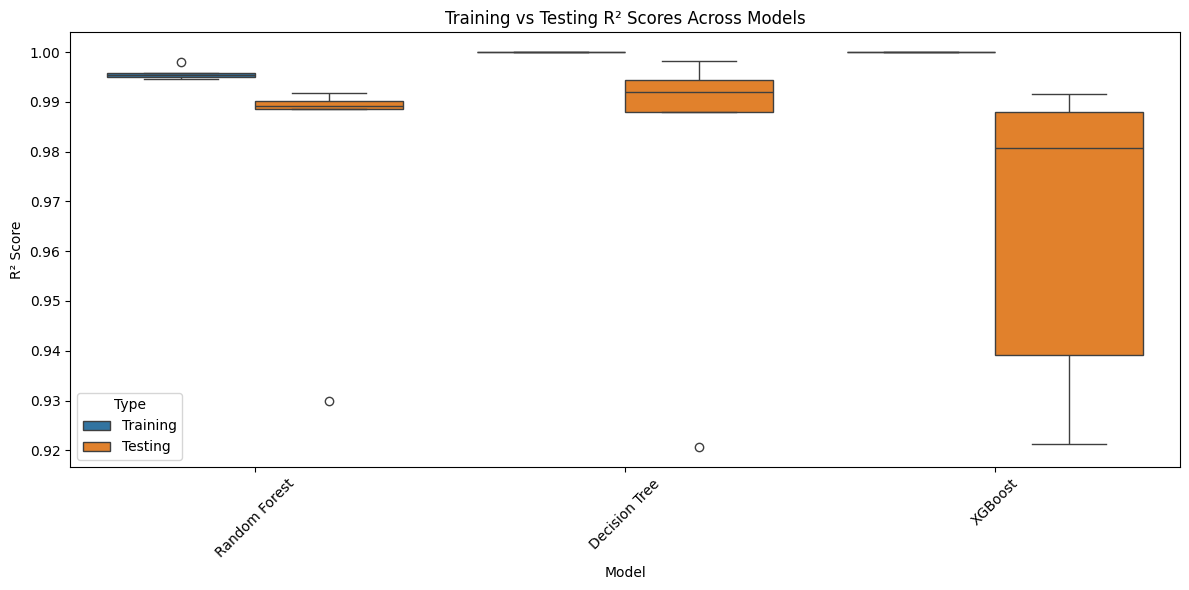


Mean R² Scores:

Random Forest:
Training R² (mean): 0.996
Testing R² (mean): 0.978

Decision Tree:
Training R² (mean): 1.000
Testing R² (mean): 0.979

XGBoost:
Training R² (mean): 1.000
Testing R² (mean): 0.964


In [75]:
# Initialize models
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Initialize lists to store R² scores
train_scores = []
test_scores = []
model_names = []

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    train_r2_scores = []
    test_r2_scores = []

    for train_idx, test_idx in kf.split(X):
        # Split data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit model
        model.fit(X_train, y_train)

        # Get predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calculate R² scores
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        train_r2_scores.append(train_r2)
        test_r2_scores.append(test_r2)

    # Store scores
    train_scores.extend(train_r2_scores)
    test_scores.extend(test_r2_scores)
    model_names.extend([name] * len(train_r2_scores))

# Create DataFrame for plotting
plot_data = pd.DataFrame({
    'Model': model_names * 2,
    'R² Score': train_scores + test_scores,
    'Type': ['Training'] * len(train_scores) + ['Testing'] * len(test_scores)
})

# Create boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=plot_data, x='Model', y='R² Score', hue='Type')
plt.xticks(rotation=45)
plt.title('Training vs Testing R² Scores Across Models')
plt.tight_layout()
plt.show()

# Print mean scores
print("\nMean R² Scores:")
for name in models.keys():
    train_mask = (plot_data['Model'] == name) & (plot_data['Type'] == 'Training')
    test_mask = (plot_data['Model'] == name) & (plot_data['Type'] == 'Testing')

    mean_train = plot_data[train_mask]['R² Score'].mean()
    mean_test = plot_data[test_mask]['R² Score'].mean()

    print(f"\n{name}:")
    print(f"Training R² (mean): {mean_train:.3f}")
    print(f"Testing R² (mean): {mean_test:.3f}")

Based on these numbers, the best model is the random forest because it is less likely to have been overfitted compared to the decision tree looking at the training R2, and the testing R2 is about the same between random forest and decision tree.

In [70]:
# Defining methods for cross validization, Hyperparameter Tuning, Feature Importance

# Time series cross-validation
def perform_time_series_cv(model, X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    cv_scores = {
        'mse': [],
        'r2': [],
        'mae': []
    }

    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        predictions = model.predict(X_val)

        cv_scores['mse'].append(mean_squared_error(y_val, predictions))
        cv_scores['r2'].append(r2_score(y_val, predictions))
        cv_scores['mae'].append(mean_absolute_error(y_val, predictions))

    return {metric: np.mean(scores) for metric, scores in cv_scores.items()}

# Hyperparameter tuning
def tune_decision_tree():
    param_grid = {
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    return DecisionTreeRegressor(), param_grid

def tune_random_forest():
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    }
    return RandomForestRegressor(), param_grid

def tune_xgboost():
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3]
    }
    return XGBRegressor(), param_grid

def perform_grid_search(model, param_grid, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    grid_search.fit(X, y)
    return grid_search.best_params_, grid_search.best_score_

# Feature importance analysis
def analyze_feature_importance(model, X, feature_names):
    importance_scores = None

    if isinstance(model, RandomForestRegressor) or isinstance(model, DecisionTreeRegressor):
        importance_scores = model.feature_importances_
    elif isinstance(model, XGBRegressor):
        importance_scores = model.feature_importances_

    if importance_scores is not None:
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance_scores
        })
        return importance_df.sort_values('importance', ascending=False)
    return None

In [76]:
# Initialize models
models = {
    'Decision Tree': tune_decision_tree(),
    'Random Forest': tune_random_forest(),
    # 'XGBoost': tune_xgboost()
}

# Perform grid search and time series CV for each model
results = {}
feature_importance_results = {}

for name, (model, param_grid) in models.items():
    print(f"\nOptimizing {name}...")

    # Hyperparameter tuning
    best_params, best_score = perform_grid_search(model, param_grid, X, y)
    print(f"Best parameters: {best_params}")
    print(f"Best cross-validated score: {-best_score}")  # Convert negative MSE back to positive

    # Create optimized model with best parameters
    if name == 'XGBoost':
        optimized_model = XGBRegressor(**best_params)
    elif name == 'Random Forest':
        optimized_model = RandomForestRegressor(**best_params)
    else:
        optimized_model = DecisionTreeRegressor(**best_params)

    # Perform time series cross-validation
    cv_scores = perform_time_series_cv(optimized_model, X, y)
    results[name] = {
        'best_params': best_params,
        'cv_scores': cv_scores
    }

    # Feature importance analysis
    optimized_model.fit(X, y)
    feature_importance = analyze_feature_importance(optimized_model, X, X.columns)
    feature_importance_results[name] = feature_importance


Optimizing Decision Tree...
Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best cross-validated score: 2617566787390.7764

Optimizing Random Forest...
Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validated score: 3222366053314.2417


In [77]:
# Print results
print("\nCross-validation Results:")
for name, result in results.items():
    print(f"\n{name}:")
    print(f"Best parameters: {result['best_params']}")
    print(f"CV Scores:")
    print(f"  MSE: {result['cv_scores']['mse']:.3f}")
    print(f"  R²: {result['cv_scores']['r2']:.3f}")
    print(f"  MAE: {result['cv_scores']['mae']:.3f}")

    print(f"\nFeature Importance:")
    print(feature_importance_results[name])


Cross-validation Results:

Decision Tree:
Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
CV Scores:
  MSE: 3168908049614.324
  R²: -3.753
  MAE: 1315565.805

Feature Importance:
     feature  importance
0  BTCENEGUE    0.921831
1       Year    0.063638
3        Day    0.009730
2      Month    0.004800

Random Forest:
Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
CV Scores:
  MSE: 3275299653067.555
  R²: -3.874
  MAE: 1345657.489

Feature Importance:
     feature  importance
0  BTCENEGUE    0.898779
1       Year    0.061374
3        Day    0.022261
2      Month    0.017586


hyperparameterization made the model much worse (R2 are not negative for both models). The best model to use would be the random forest model without hyperparameterization.